In [30]:
try:
    import os
    import requests
    import networkx as nx
    import matplotlib.pyplot as plt
    from dotenv import load_dotenv

    load_dotenv('../Docs/.env')

except Exception as e:
    print(f"Error : {e}")

In [31]:
base_url = 'https://api.tfl.gov.uk'
app_key = os.getenv('app_key')

# Get all stations and their information
response = requests.get(f'{base_url}/StopPoint/Mode/tube?app_key={app_key}')
tube_stations = response.json()

In [32]:
# Check the structure of the response data
for station in tube_stations['stopPoints'][:5]:
    print(station)

{'$type': 'Tfl.Api.Presentation.Entities.StopPoint, Tfl.Api.Presentation.Entities', 'naptanId': '0400ZZLUAMS0', 'indicator': 'main entrance', 'stopLetter': 'entrance', 'modes': ['tube'], 'icsCode': '1000006', 'stopType': 'NaptanMetroEntrance', 'stationNaptan': '940GZZLUAMS', 'hubNaptanCode': 'HUBAMR', 'lines': [], 'lineGroup': [], 'lineModeGroups': [], 'status': True, 'id': '0400ZZLUAMS0', 'commonName': 'Amersham Underground Station', 'placeType': 'StopPoint', 'additionalProperties': [{'$type': 'Tfl.Api.Presentation.Entities.AdditionalProperties, Tfl.Api.Presentation.Entities', 'category': 'Facility', 'key': 'Car park', 'sourceSystemKey': 'StaticObjects', 'value': 'yes'}, {'$type': 'Tfl.Api.Presentation.Entities.AdditionalProperties, Tfl.Api.Presentation.Entities', 'category': 'Facility', 'key': 'Payphones', 'sourceSystemKey': 'StaticObjects', 'value': '1'}, {'$type': 'Tfl.Api.Presentation.Entities.AdditionalProperties, Tfl.Api.Presentation.Entities', 'category': 'Facility', 'key': 'Ph

In [33]:
# Create a NetworkX graph
transport_network = nx.Graph()

# Add stations (nodes) to the graph
for station in tube_stations['stopPoints']:
    # Ensure the stop type is an actual station (not an entrance or similar)
    if station['stopType'] == 'NaptanMetroStation' and 'tube' in station['modes']:
        station_id = station['naptanId']  # Use station Naptan ID for better uniqueness
        station_name = station['commonName']
        latitude = station['lat']
        longitude = station['lon']
        lines = [line['id'] for line in station.get('lines', [])]

        if lines:  # Only add stations with at least one Tube line
            transport_network.add_node(
                station_id,
                name=station_name,
                pos=(longitude, latitude),
                lines=lines
            )


In [34]:
# Get all Tube lines to dynamically obtain line IDs
response = requests.get(f'{base_url}/Line/Mode/tube?app_key={app_key}')
all_lines = response.json()
line_ids = [line['id'] for line in all_lines]

# Loop through each line to add connections
for line_id in line_ids:
    response = requests.get(f'{base_url}/Line/{line_id}/Route/Sequence/all?app_key={app_key}')
    line_data = response.json()

    if 'orderedLineRoutes' in line_data:
        for direction in line_data['orderedLineRoutes']:
            stations = direction['naptanIds']  # List of station IDs in order for the route

            # Loop through station pairs to create edges
            for i in range(len(stations) - 1):
                start_station = stations[i]
                end_station = stations[i + 1]

                if transport_network.has_node(start_station) and transport_network.has_node(end_station):
                    transport_network.add_edge(
                        start_station,
                        end_station,
                        line=line_id
                    )

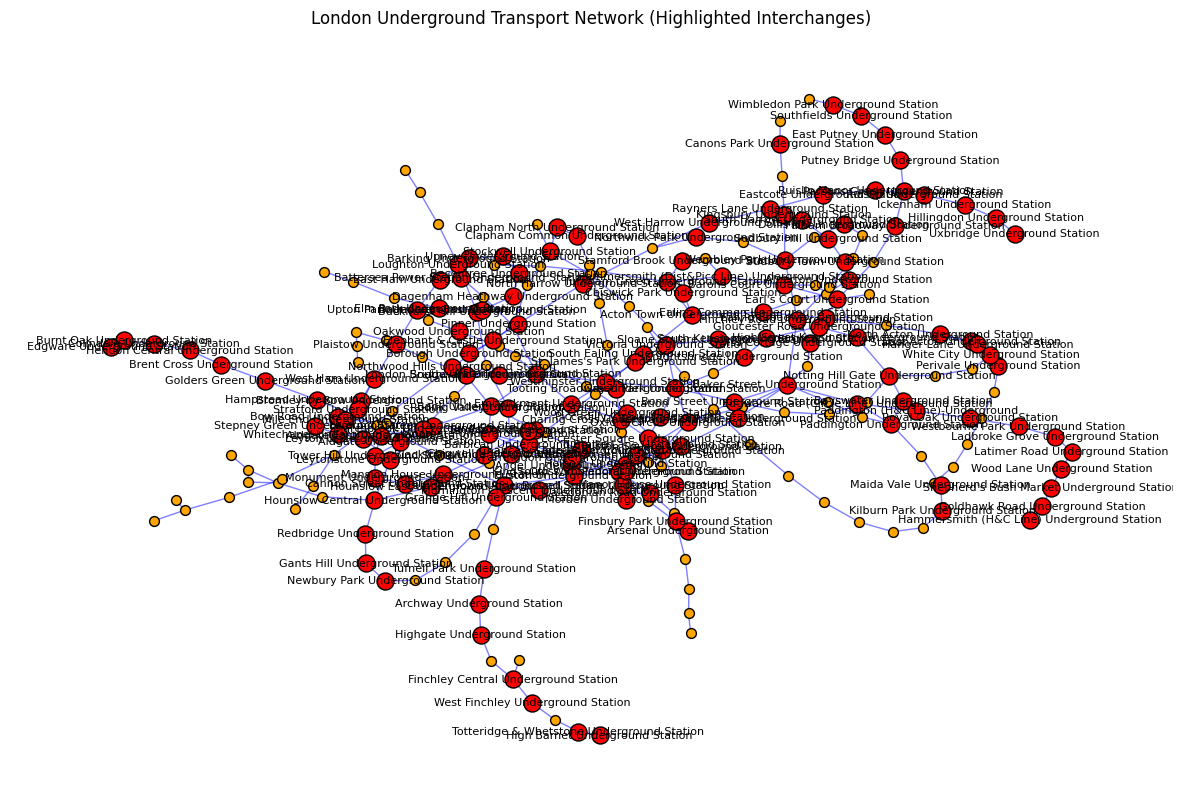

In [35]:
plt.figure(figsize=(15, 10))

# Redefine positions to use spring layout
pos = nx.spring_layout(transport_network, seed=42)

# Draw nodes (stations)
nx.draw_networkx_nodes(transport_network, pos, node_size=50, node_color='orange', edgecolors='black')

# Draw edges (connections)
nx.draw_networkx_edges(transport_network, pos, alpha=0.5, edge_color='blue')

# Highlight interchange stations with larger size and different color
interchange_stations = [node for node, data in transport_network.nodes(data=True) if len(data['lines']) > 1]
nx.draw_networkx_nodes(transport_network, pos, nodelist=interchange_stations, node_size=150, node_color='red', edgecolors='black')

# Only label interchange stations for clarity
interchange_labels = {node: data['name'] for node, data in transport_network.nodes(data=True) if len(data['lines']) > 1}
nx.draw_networkx_labels(transport_network, pos, labels=interchange_labels, font_size=8, font_family='sans-serif')

plt.title("London Underground Transport Network (Highlighted Interchanges)")
plt.axis('off')
plt.show()

In [36]:
if nx.is_connected(transport_network):
    print("The graph is connected.")
else:
    print("The graph is NOT connected.")

The graph is connected.


Network is connected


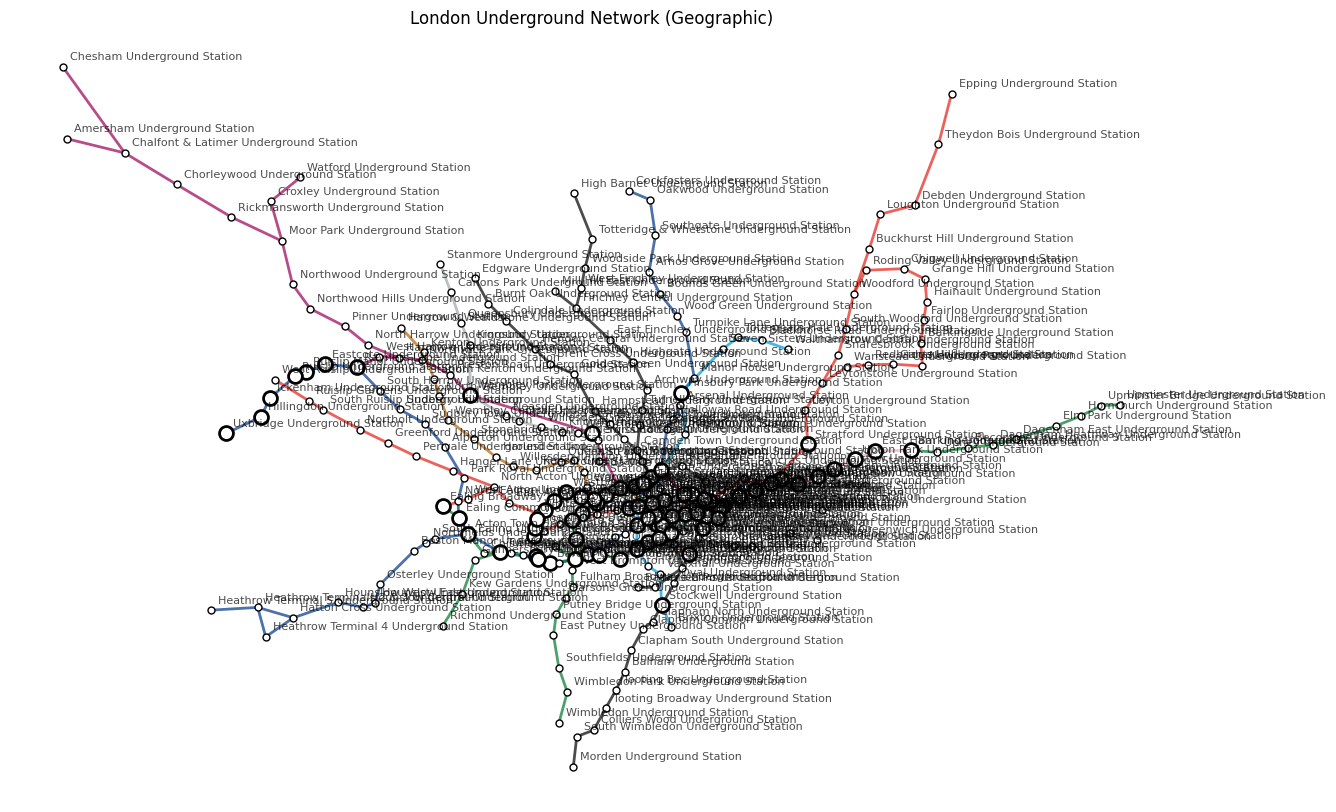

In [39]:
# First, let's improve the data fetching and organization
import os
import requests
import networkx as nx
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import folium
from geopy.distance import geodesic

class LondonTubeNetwork:
    def __init__(self, app_key):
        self.base_url = 'https://api.tfl.gov.uk'
        self.app_key = app_key
        self.G = nx.Graph()
        self.line_colors = {
            'bakerloo': '#B36305',
            'central': '#E32017',
            'circle': '#FFD300',
            'district': '#00782A',
            'hammersmith-city': '#F3A9BB',
            'jubilee': '#A0A5A9',
            'metropolitan': '#9B0056',
            'northern': '#000000',
            'piccadilly': '#003688',
            'victoria': '#0098D4',
            'waterloo-city': '#95CDBA'
        }

    def fetch_tube_data(self):
        """Fetch all tube stations and lines from TfL API"""
        # Get all tube stations
        response = requests.get(f'{self.base_url}/StopPoint/Mode/tube?app_key={self.app_key}')
        self.tube_stations = response.json()

        # Get all tube lines
        response = requests.get(f'{self.base_url}/Line/Mode/tube?app_key={self.app_key}')
        self.tube_lines = response.json()

    def build_network(self):
        """Build network from TfL data"""
        # Add stations as nodes
        for station in self.tube_stations['stopPoints']:
            if station['stopType'] == 'NaptanMetroStation' and 'tube' in station['modes']:
                station_id = station['naptanId']
                self.G.add_node(
                    station_id,
                    name=station['commonName'],
                    pos=(station['lon'], station['lat']),
                    lines=set()
                )

        # Add connections from line sequence data
        for line in self.tube_lines:
            line_id = line['id']
            response = requests.get(
                f'{self.base_url}/Line/{line_id}/Route/Sequence/all?app_key={self.app_key}'
            )
            line_data = response.json()

            if 'orderedLineRoutes' in line_data:
                for route in line_data['orderedLineRoutes']:
                    stations = route['naptanIds']
                    for i in range(len(stations) - 1):
                        start_station = stations[i]
                        end_station = stations[i + 1]
                        
                        if self.G.has_node(start_station) and self.G.has_node(end_station):
                            # Add line to station's lines set
                            self.G.nodes[start_station]['lines'].add(line_id)
                            self.G.nodes[end_station]['lines'].add(line_id)
                            
                            # Calculate distance using coordinates
                            start_pos = self.G.nodes[start_station]['pos']
                            end_pos = self.G.nodes[end_station]['pos']
                            distance = geodesic(
                                (start_pos[1], start_pos[0]),
                                (end_pos[1], end_pos[0])
                            ).kilometers

                            # Add edge with line color and distance
                            self.G.add_edge(
                                start_station,
                                end_station,
                                line=line_id,
                                color=self.line_colors.get(line_id.lower(), '#808080'),
                                distance=round(distance, 2)
                            )

    def create_schematic_map(self):
        """Create a schematic network visualization"""
        plt.figure(figsize=(15, 10))
        
        # Use geographic coordinates for position
        pos = {node: data['pos'] for node, data in self.G.nodes(data=True)}
        
        # Draw edges (colored by line)
        for (u, v, data) in self.G.edges(data=True):
            plt.plot(
                [pos[u][0], pos[v][0]], 
                [pos[u][1], pos[v][1]],
                color=data['color'],
                linewidth=2,
                alpha=0.7
            )

        # Draw stations
        for node, data in self.G.nodes(data=True):
            size = 100 if len(data['lines']) > 1 else 50
            plt.plot(
                data['pos'][0],
                data['pos'][1],
                'o',
                color='white',
                markeredgecolor='black',
                markersize=size/10,
                markeredgewidth=2 if len(data['lines']) > 1 else 1
            )
            
            # Add station labels
            plt.annotate(
                data['name'],
                (data['pos'][0], data['pos'][1]),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8,
                alpha=0.7
            )

        plt.title("London Underground Network (Geographic)")
        plt.axis('off')
        return plt

    def create_folium_map(self):
        """Create an interactive map using Folium"""
        # Create map centered on London
        m = folium.Map(
            location=[51.5074, -0.1278],
            zoom_start=12,
            tiles='cartodbpositron'
        )

        # Add stations and lines
        for (u, v, data) in self.G.edges(data=True):
            # Draw line connections
            line_coords = [
                [self.G.nodes[u]['pos'][1], self.G.nodes[u]['pos'][0]],
                [self.G.nodes[v]['pos'][1], self.G.nodes[v]['pos'][0]]
            ]
            folium.PolyLine(
                line_coords,
                color=data['color'],
                weight=3,
                opacity=0.7,
                popup=f"{data['line']} Line - {data['distance']:.2f}km"
            ).add_to(m)

        # Add stations
        for node, data in self.G.nodes(data=True):
            is_interchange = len(data['lines']) > 1
            folium.CircleMarker(
                location=[data['pos'][1], data['pos'][0]],
                radius=8 if is_interchange else 5,
                color='black',
                fill=True,
                fill_color='white',
                weight=2 if is_interchange else 1,
                popup=f"{data['name']}<br>Lines: {', '.join(data['lines'])}"
            ).add_to(m)

        return m

# Usage example:
load_dotenv('../Docs/.env')
app_key = os.getenv('app_key')

# Create and build network
network = LondonTubeNetwork(app_key)
network.fetch_tube_data()
network.build_network()

# Check if network is connected
print(f"Network is {'connected' if nx.is_connected(network.G) else 'NOT connected'}")

# Create visualizations
plt = network.create_schematic_map()
plt.show()

# Create interactive map
m = network.create_folium_map()
m.save('london_tube_map.html')

In [49]:
from pydoc import Doc
from typing import Dict, List, Optional, Set, Tuple
import os
import logging
from datetime import datetime
import requests
import networkx as nx
import matplotlib.pyplot as plt
import folium
from IPython.display import display
from geopy.distance import geodesic
from dotenv import load_dotenv
from dataclasses import dataclass
from abc import ABC, abstractmethod

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

@dataclass
class Station:
    """Data class representing a tube station"""
    id: str
    name: str
    latitude: float
    longitude: float
    lines: Set[str]
    zone: Optional[str] = None

class MapVisualizer(ABC):
    """Abstract base class for map visualizations"""
    @abstractmethod
    def create_map(self, network: 'LondonTubeNetwork') -> None:
        pass

class SchematicMapVisualizer(MapVisualizer):
    """Creates a schematic visualization using matplotlib"""
    def create_map(self, network: 'LondonTubeNetwork') -> plt.Figure:
        """
        Creates a schematic map visualization.
        
        Args:
            network: LondonTubeNetwork instance containing the network data
            
        Returns:
            matplotlib.figure.Figure: The created visualization
        """
        fig = plt.figure(figsize=(15, 10))
        
        # Use geographic coordinates for position
        pos = {node: (data['pos'][0], data['pos'][1]) 
               for node, data in network.G.nodes(data=True)}
        
        # Draw edges (colored by line)
        drawn_lines = set()
        for (u, v, data) in network.G.edges(data=True):
            plt.plot(
                [pos[u][0], pos[v][0]], 
                [pos[u][1], pos[v][1]],
                color=data['color'],
                linewidth=2,
                alpha=0.7,
                label=data['line'] if data['line'] not in drawn_lines else "",
                zorder=1
            )
            drawn_lines.add(data['line'])

        # Draw stations
        for node, data in network.G.nodes(data=True):
            is_interchange = len(data['lines']) > 1
            plt.plot(
                data['pos'][0],
                data['pos'][1],
                'o',
                color='white',
                markeredgecolor='black',
                markersize=12 if is_interchange else 8,
                markeredgewidth=2 if is_interchange else 1,
                zorder=2
            )
            
            # Add station labels with improved positioning
            plt.annotate(
                data['name'],
                (data['pos'][0], data['pos'][1]),
                xytext=(10, 10),
                textcoords='offset points',
                fontsize=8,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7),
                zorder=3
            )

        plt.title("London Underground Network", pad=20, fontsize=16)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.axis('off')
        return plt

class InteractiveMapVisualizer(MapVisualizer):
    """Creates an interactive visualization using Folium"""
    def create_map(self, network: 'LondonTubeNetwork') -> folium.Map:
        """
        Creates an interactive map visualization.
        
        Args:
            network: LondonTubeNetwork instance containing the network data
            
        Returns:
            folium.Map: The created interactive map
        """
        m = folium.Map(
            location=[51.5074, -0.1278],
            zoom_start=12,
            tiles='cartodbpositron'
        )

        # Add lines with distances
        for (u, v, data) in network.G.edges(data=True):
            line_coords = [
                [network.G.nodes[u]['pos'][1], network.G.nodes[u]['pos'][0]],
                [network.G.nodes[v]['pos'][1], network.G.nodes[v]['pos'][0]]
            ]
            
            # Create popup with distance and line information
            popup_html = f"""
                <div style="font-family: Arial, sans-serif;">
                    <h4>{data['line']} Line</h4>
                    <p>Distance: {data['distance']:.2f}km</p>
                    <p>Stations: {network.G.nodes[u]['name']} → {network.G.nodes[v]['name']}</p>
                </div>
            """
            
            folium.PolyLine(
                line_coords,
                color=data['color'],
                weight=3,
                opacity=0.7,
                popup=folium.Popup(popup_html, max_width=300)
            ).add_to(m)

        # Add stations with detailed information
        for node, data in network.G.nodes(data=True):
            is_interchange = len(data['lines']) > 1
            
            # Create detailed station popup
            popup_html = f"""
                <div style="font-family: Arial, sans-serif;">
                    <h4>{data['name']}</h4>
                    <p>Lines: {', '.join(data['lines'])}</p>
                    <p>Zone: {data.get('zone', 'Unknown')}</p>
                    <p>Type: {'Interchange' if is_interchange else 'Regular'} Station</p>
                </div>
            """
            
            folium.CircleMarker(
                location=[data['pos'][1], data['pos'][0]],
                radius=8 if is_interchange else 5,
                color='black',
                fill=True,
                fill_color='white',
                weight=2 if is_interchange else 1,
                popup=folium.Popup(popup_html, max_width=300)
            ).add_to(m)

        return m

class LondonTubeNetwork:
    """
    Main class for handling the London Underground network data and visualization.
    
    Attributes:
        base_url (str): Base URL for TfL API
        app_key (str): API key for TfL
        G (nx.Graph): NetworkX graph representing the tube network
        line_colors (dict): Mapping of line names to their official TfL colors
    """
    
    def __init__(self, app_key: str):
        """
        Initialize the network with TfL API key.
        
        Args:
            app_key: TfL API key for authentication
        """
        self.base_url = 'https://api.tfl.gov.uk'
        self.app_key = app_key
        self.G = nx.Graph()
        self.line_colors = {
            'bakerloo': '#B36305',
            'central': '#E32017',
            'circle': '#FFD300',
            'district': '#00782A',
            'hammersmith-city': '#F3A9BB',
            'jubilee': '#A0A5A9',
            'metropolitan': '#9B0056',
            'northern': '#000000',
            'piccadilly': '#003688',
            'victoria': '#0098D4',
            'waterloo-city': '#95CDBA'
        }
        
        # Create visualizers
        self.schematic_visualizer = SchematicMapVisualizer()
        self.interactive_visualizer = InteractiveMapVisualizer()

    def fetch_tube_data(self) -> Tuple[Optional[dict], Optional[dict]]:
        """
        Fetch tube station and line data from TfL API.
        
        Returns:
            Tuple containing station and line data dictionaries
        
        Raises:
            requests.RequestException: If API calls fail
        """
        try:
            # Fetch stations
            response = requests.get(
                f'{self.base_url}/StopPoint/Mode/tube',
                params={'app_key': self.app_key}
            )
            response.raise_for_status()
            stations = response.json()
            
            # Fetch lines
            response = requests.get(
                f'{self.base_url}/Line/Mode/tube',
                params={'app_key': self.app_key}
            )
            response.raise_for_status()
            lines = response.json()
            
            return stations, lines
            
        except requests.RequestException as e:
            logger.error(f"Error fetching tube data: {e}")
            return None, None

    def build_network(self) -> bool:
        """
        Build network from TfL data.
        
        Returns:
            bool: True if network was built successfully
        """
        stations, lines = self.fetch_tube_data()
        if not stations or not lines:
            return False

        try:
            # Add stations as nodes
            for station in stations['stopPoints']:
                if (station['stopType'] == 'NaptanMetroStation' 
                    and 'tube' in station['modes']):
                    station_id = station['naptanId']
                    
                    # Extract zone information if available
                    zone = None
                    for prop in station.get('additionalProperties', []):
                        if prop.get('key') == 'Zone':
                            zone = prop.get('value')
                            break
                    
                    self.G.add_node(
                        station_id,
                        name=station['commonName'],
                        pos=(station['lon'], station['lat']),
                        lines=set(),
                        zone=zone
                    )

            # Add connections
            for line in lines:
                self._add_line_connections(line['id'])

            return True
            
        except Exception as e:
            logger.error(f"Error building network: {e}")
            return False

    def _add_line_connections(self, line_id: str) -> None:
        """
        Add connections for a specific line.
        
        Args:
            line_id: ID of the line to add connections for
        """
        try:
            response = requests.get(
                f'{self.base_url}/Line/{line_id}/Route/Sequence/all',
                params={'app_key': self.app_key}
            )
            response.raise_for_status()
            line_data = response.json()

            if 'orderedLineRoutes' in line_data:
                for route in line_data['orderedLineRoutes']:
                    stations = route['naptanIds']
                    for i in range(len(stations) - 1):
                        self._add_connection(
                            stations[i],
                            stations[i + 1],
                            line_id
                        )
                        
        except requests.RequestException as e:
            logger.error(f"Error fetching line data for {line_id}: {e}")

    def _add_connection(self, start_station: str, end_station: str, line_id: str) -> None:
        """
        Add a connection between two stations.
        
        Args:
            start_station: ID of the starting station
            end_station: ID of the ending station
            line_id: ID of the line connecting the stations
        """
        if (self.G.has_node(start_station) 
            and self.G.has_node(end_station)):
            # Add line to station's lines set
            self.G.nodes[start_station]['lines'].add(line_id)
            self.G.nodes[end_station]['lines'].add(line_id)
            
            # Calculate distance
            start_pos = self.G.nodes[start_station]['pos']
            end_pos = self.G.nodes[end_station]['pos']
            distance = geodesic(
                (start_pos[1], start_pos[0]),
                (end_pos[1], end_pos[0])
            ).kilometers

            # Add edge with line color and distance
            self.G.add_edge(
                start_station,
                end_station,
                line=line_id,
                color=self.line_colors.get(line_id.lower(), '#808080'),
                distance=round(distance, 2)
            )

    def validate_network(self) -> bool:
        """
        Validate the network meets coursework requirements.
        
        Requirements:
        - Network must be connected
        - Must have at least 5 different lines
        - Each line must have at least 5 stations
        
        Returns:
            bool: True if network meets all requirements
        """
        # Check if network is connected
        if not nx.is_connected(self.G):
            logger.error("Network is not connected")
            return False
                
        # Get all unique lines in the network
        all_lines = set()
        for _, data in self.G.nodes(data=True):
            all_lines.update(data['lines'])
        
        # Check number of lines
        if len(all_lines) < 5:
            logger.error(f"Network has only {len(all_lines)} lines, minimum required is 5")
            return False
        
        # Check stations per line
        for line in all_lines:
            stations_on_line = sum(1 for _, data in self.G.nodes(data=True) 
                                if line in data['lines'])
            if stations_on_line < 5:
                logger.error(f"Line {line} has only {stations_on_line} stations, minimum required is 5")
                return False
        
        # Print success statistics
        logger.info(f"Network validation successful:")
        logger.info(f"- Number of lines: {len(all_lines)}")
        logger.info(f"- Lines: {', '.join(sorted(all_lines))}")
        logger.info(f"- Number of stations: {self.G.number_of_nodes()}")
        logger.info(f"- Number of connections: {self.G.number_of_edges()}")
                
        return True

    def get_network_stats(self) -> Dict:
        """
        Get statistical information about the network.
        
        Returns:
            dict: Network statistics
        """
        return {
            'num_stations': self.G.number_of_nodes(),
            'num_connections': self.G.number_of_edges(),
            'num_interchanges': sum(
                1 for _, data in self.G.nodes(data=True) 
                if len(data['lines']) > 1
            ),
            'total_distance': sum(
                data['distance'] 
                for _, _, data in self.G.edges(data=True)
            ),
            'is_connected': nx.is_connected(self.G)
        }

    def visualize(self, output_path: Optional[str] = None) -> None:
        """Create both static and interactive visualizations"""
        # Create schematic map
        plt = self.create_schematic_map()
        plt.show()
        
        # Create and display interactive map
        m = self.create_folium_map()
        display(m)
        
        # Optionally save to file if path provided
        if output_path:
            m.save(output_path)

def main():
    """Main function to demonstrate usage"""
    # Load environment variables
    load_dotenv('../Docs/.env')
    app_key = os.getenv('TFL_APP_KEY')
    
    if not app_key:
        logger.error("No TfL API key found in environment variables")
        return
    
    # Create network
    network = LondonTubeNetwork(app_key)
    
    # Build and validate network
    if network.build_network() and network.validate_network():
        # Print statistics
        stats = network.get_network_stats()
        logger.info("Network Statistics:")
        for key, value in stats.items():
            logger.info(f"{key}: {value}")
        
        # Create visualizations
        network.visualize('london_tube_map.html')
    else:
        logger.error("Failed to build valid network")

if __name__ == "__main__":
    main()

ERROR:__main__:Line waterloo-city has only 2 stations, minimum required is 5
ERROR:__main__:Failed to build valid network


In [ ]:
import os
import logging
from typing import Dict, List, Optional, Set, Tuple
from collections import defaultdict
from IPython.display import display
import requests
import networkx as nx
import matplotlib.pyplot as plt
import folium
from geopy.distance import geodesic
from dotenv import load_dotenv

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger(__name__)

class LondonTubeNetwork:
    """
    Comprehensive implementation of London Underground network visualization.
    Includes data fetching, filtering, and multiple visualization options.
    """
    
    def __init__(self, app_key: str):
        """Initialize with TfL API key"""
        self.base_url = 'https://api.tfl.gov.uk'
        self.app_key = app_key
        self.G = nx.Graph()
        # Official TfL line colors
        self.line_colors = {
            'bakerloo': '#B36305',
            'central': '#E32017',
            'circle': '#FFD300',
            'district': '#00782A',
            'hammersmith-city': '#F3A9BB',
            'jubilee': '#A0A5A9',
            'metropolitan': '#9B0056',
            'northern': '#000000',
            'piccadilly': '#003688',
            'victoria': '#0098D4',
            'waterloo-city': '#95CDBA'
        }
        # Add station colors
        self.station_colors = {
            'regular': 'yellow',
            'interchange': 'red',
            'edge': 'black'
        }

    def fetch_tube_data(self) -> Tuple[Optional[dict], Optional[dict]]:
        """Fetch station and line data from TfL API"""
        try:
            # Fetch stations
            response = requests.get(
                f'{self.base_url}/StopPoint/Mode/tube',
                params={'app_key': self.app_key}
            )
            response.raise_for_status()
            stations = response.json()
            
            # Fetch lines
            response = requests.get(
                f'{self.base_url}/Line/Mode/tube',
                params={'app_key': self.app_key}
            )
            response.raise_for_status()
            lines = response.json()
            
            return stations, lines
            
        except requests.RequestException as e:
            logger.error(f"Error fetching tube data: {e}")
            return None, None

    def analyze_network_data(self, stations: dict, lines: dict) -> Optional[dict]:
        """Analyze and filter network data to meet coursework requirements"""
        station_lines = defaultdict(set)
        line_stations = defaultdict(set)
        
        # Process stations
        valid_stations = {}
        for station in stations['stopPoints']:
            if station['stopType'] == 'NaptanMetroStation' and 'tube' in station['modes']:
                station_id = station['naptanId']
                valid_stations[station_id] = {
                    'name': station['commonName'],
                    'lat': station['lat'],
                    'lon': station['lon']
                }

        # Process lines and their stations
        for line in lines:
            line_id = line['id']
            try:
                response = requests.get(
                    f'{self.base_url}/Line/{line_id}/Route/Sequence/all',
                    params={'app_key': self.app_key}
                )
                response.raise_for_status()
                line_data = response.json()

                if 'orderedLineRoutes' in line_data:
                    for route in line_data['orderedLineRoutes']:
                        for station_id in route['naptanIds']:
                            if station_id in valid_stations:
                                station_lines[station_id].add(line_id)
                                line_stations[line_id].add(station_id)
                                
            except requests.RequestException as e:
                logger.warning(f"Error fetching data for line {line_id}: {e}")

        # Filter lines with sufficient stations
        valid_lines = {
            line_id: stations 
            for line_id, stations in line_stations.items() 
            if len(stations) >= 5
        }

        if len(valid_lines) >= 5:
            # Select top 5 lines with most stations
            selected_lines = dict(
                sorted(valid_lines.items(), 
                      key=lambda x: len(x[1]), 
                      reverse=True)[:5]
            )
            
            # Get stations for selected lines
            selected_stations = set()
            for stations in selected_lines.values():
                selected_stations.update(stations)

            return {
                'stations': {
                    station_id: {
                        **valid_stations[station_id],
                        'lines': station_lines[station_id]
                    }
                    for station_id in selected_stations
                },
                'lines': selected_lines,
                'stats': {
                    'num_stations': len(selected_stations),
                    'num_lines': len(selected_lines),
                    'lines_info': {
                        line: len(stations) 
                        for line, stations in selected_lines.items()
                    }
                }
            }
        
        return None

    def build_filtered_network(self) -> bool:
        """Build network with filtered data meeting requirements"""
        stations, lines = self.fetch_tube_data()
        if not stations or not lines:
            return False

        analysis = self.analyze_network_data(stations, lines)
        if not analysis:
            logger.error("Insufficient data meeting requirements")
            return False

        # Log analysis results
        logger.info("\nNetwork Analysis:")
        logger.info("Selected Lines:")
        for line, stations in analysis['lines'].items():
            logger.info(f"- {line}: {len(stations)} stations")
        logger.info(f"Total Stations: {analysis['stats']['num_stations']}")

        # Build network with filtered data
        self._build_network_from_analysis(analysis)
        return True

    def _build_network_from_analysis(self, analysis: dict) -> None:
        """Build network from analyzed data"""
        # Add stations
        for station_id, station_data in analysis['stations'].items():
            self.G.add_node(
                station_id,
                name=station_data['name'],
                pos=(station_data['lon'], station_data['lat']),
                lines=station_data['lines']
            )

        # Add connections
        for line_id in analysis['lines'].keys():
            try:
                response = requests.get(
                    f'{self.base_url}/Line/{line_id}/Route/Sequence/all',
                    params={'app_key': self.app_key}
                )
                response.raise_for_status()
                line_data = response.json()

                if 'orderedLineRoutes' in line_data:
                    for route in line_data['orderedLineRoutes']:
                        stations = route['naptanIds']
                        for i in range(len(stations) - 1):
                            self._add_connection(
                                stations[i],
                                stations[i + 1],
                                line_id
                            )
                            
            except requests.RequestException as e:
                logger.error(f"Error fetching line data for {line_id}: {e}")

    def _add_connection(self, start_station: str, end_station: str, line_id: str) -> None:
        """Add a connection between stations"""
        if (self.G.has_node(start_station) 
            and self.G.has_node(end_station)
            and not self.G.has_edge(start_station, end_station)):
            
            # Calculate distance
            start_pos = self.G.nodes[start_station]['pos']
            end_pos = self.G.nodes[end_station]['pos']
            distance = geodesic(
                (start_pos[1], start_pos[0]),
                (end_pos[1], end_pos[0])
            ).kilometers

            # Add edge
            self.G.add_edge(
                start_station,
                end_station,
                line=line_id,
                color=self.line_colors.get(line_id.lower(), '#808080'),
                distance=round(distance, 2)
            )

    def create_schematic_map(self) -> plt.Figure:
        """Create schematic network visualization"""
        plt.figure(figsize=(15, 10))
        
        # Use geographic coordinates
        pos = {node: data['pos'] for node, data in self.G.nodes(data=True)}
        
        # Draw edges (lines)
        drawn_lines = set()
        for (u, v, data) in self.G.edges(data=True):
            plt.plot(
                [pos[u][0], pos[v][0]], 
                [pos[u][1], pos[v][1]],
                color=data['color'],
                linewidth=2,
                alpha=0.7,
                label=data['line'] if data['line'] not in drawn_lines else "",
                zorder=1
            )
            drawn_lines.add(data['line'])

        # Draw stations
        for node, data in self.G.nodes(data=True):
            is_interchange = len(data['lines']) > 1
            plt.plot(
                data['pos'][0],
                data['pos'][1],
                'o',
                color=self.station_colors['interchange'] if is_interchange else self.station_colors['regular'],
                markeredgecolor=self.station_colors['edge'],
                markersize=12 if is_interchange else 8,
                markeredgewidth=2 if is_interchange else 1,
                zorder=2
            )

            # Add station labels
            plt.annotate(
                data['name'],
                (data['pos'][0], data['pos'][1]),
                xytext=(10, 10),
                textcoords='offset points',
                fontsize=8,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7),
                zorder=3
            )

        plt.title("London Underground Network (Selected Lines)", pad=20, fontsize=16)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.axis('off')
        return plt

    def create_folium_map(self) -> folium.Map:
        """Create interactive network visualization"""
        m = folium.Map(
            location=[51.5074, -0.1278],
            zoom_start=12,
            tiles='cartodbpositron'
        )

        # Add lines
        for (u, v, data) in self.G.edges(data=True):
            line_coords = [
                [self.G.nodes[u]['pos'][1], self.G.nodes[u]['pos'][0]],
                [self.G.nodes[v]['pos'][1], self.G.nodes[v]['pos'][0]]
            ]
            
            # Create popup
            popup_html = f"""
                <div style="font-family: Arial, sans-serif;">
                    <h4>{data['line']} Line</h4>
                    <p>Distance: {data['distance']:.2f}km</p>
                    <p>Stations: {self.G.nodes[u]['name']} → {self.G.nodes[v]['name']}</p>
                </div>
            """
            
            folium.PolyLine(
                line_coords,
                color=data['color'],
                weight=3,
                opacity=0.7,
                popup=folium.Popup(popup_html, max_width=300)
            ).add_to(m)

        # Add stations
        for node, data in self.G.nodes(data=True):
            is_interchange = len(data['lines']) > 1
            
            popup_html = f"""
                <div style="font-family: Arial, sans-serif;">
                    <h4>{data['name']}</h4>
                    <p>Lines: {', '.join(data['lines'])}</p>
                    <p>Type: {'Interchange' if is_interchange else 'Regular'} Station</p>
                </div>
            """
            
            folium.CircleMarker(
                location=[data['pos'][1], data['pos'][0]],
                radius=8 if is_interchange else 5,
                color=self.station_colors['edge'],
                fill=True,
                fill_color=self.station_colors['interchange'] if is_interchange else self.station_colors['regular'],
                weight=2 if is_interchange else 1,
                popup=folium.Popup(popup_html, max_width=300)
            ).add_to(m)

        return m
    def visualize(self, output_path: Optional[str] = None) -> None:
        """Create both static and interactive visualizations"""
        
        # Create and display interactive map
        m = self.create_folium_map()
        display(m)
        
        # Optionally save to file if path provided
        if output_path:
            m.save(output_path)

    def get_network_stats(self) -> Dict:
        """Get network statistics"""
        return {
            'num_stations': self.G.number_of_nodes(),
            'num_connections': self.G.number_of_edges(),
            'num_interchanges': sum(
                1 for _, data in self.G.nodes(data=True) 
                if len(data['lines']) > 1
            ),
            'total_distance': sum(
                data['distance'] 
                for _, _, data in self.G.edges(data=True)
            ),
            'is_connected': nx.is_connected(self.G)
        }

def main():
    """Main execution function"""
    load_dotenv('../Docs/.env')
    app_key = os.getenv('app_key')
    
    if not app_key:
        logger.error("No TfL API key found")
        return
    
    # Create and build filtered network
    network = LondonTubeNetwork(app_key)
    if network.build_filtered_network():
        # Print statistics
        stats = network.get_network_stats()
        logger.info("\nNetwork Statistics:")
        for key, value in stats.items():
            logger.info(f"{key}: {value}")
        
        # Create visualizations
        network.visualize('london_tube_map.html')
    else:
        logger.error("Failed to build network")

if __name__ == "__main__":
    main()

INFO:__main__:
Network Analysis:
INFO:__main__:Selected Lines:
INFO:__main__:- district: 60 stations
INFO:__main__:- piccadilly: 53 stations
INFO:__main__:- northern: 52 stations
INFO:__main__:- central: 49 stations
INFO:__main__:- circle: 36 stations
INFO:__main__:Total Stations: 212
INFO:__main__:
Network Statistics:
INFO:__main__:num_stations: 212
INFO:__main__:num_connections: 230
INFO:__main__:num_interchanges: 78
INFO:__main__:total_distance: 272.32000000000005
INFO:__main__:is_connected: True


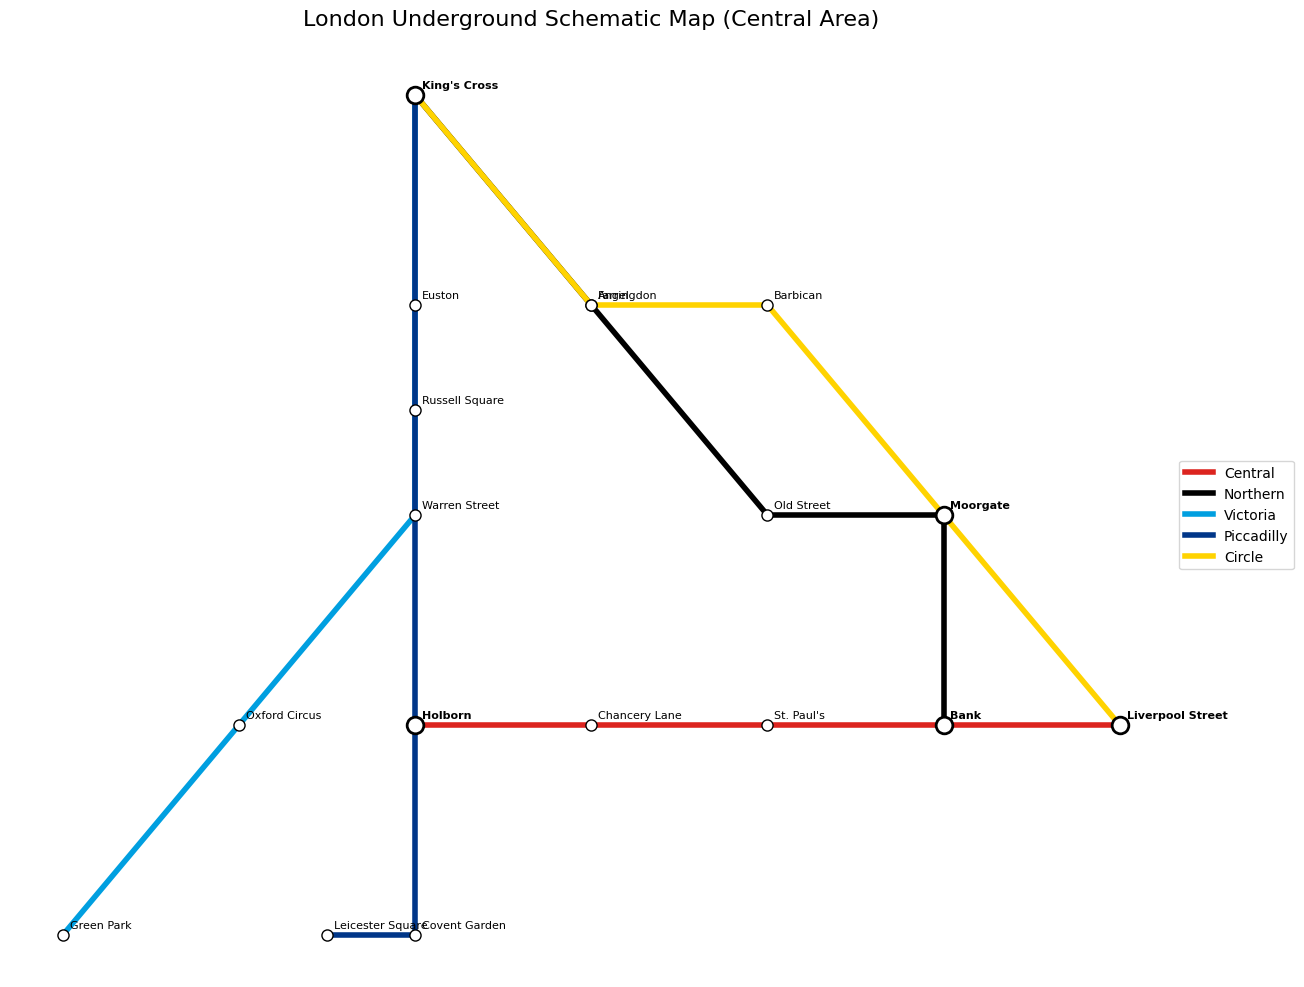

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle, Circle

class LondonTubeSchematic:
    def __init__(self):
        self.G = nx.Graph()
        # Define lines with official TfL colors and simplified coordinates
        self.lines = {
            'Central': {
                'color': '#DC241F',
                'stations': [
                    ('Liverpool Street', (8, 5)),
                    ('Bank', (7, 5)),
                    ('St. Paul\'s', (6, 5)),
                    ('Chancery Lane', (5, 5)),
                    ('Holborn', (4, 5))
                ]
            },
            'Northern': {
                'color': '#000000',
                'stations': [
                    ('King\'s Cross', (4, 8)),
                    ('Angel', (5, 7)),
                    ('Old Street', (6, 6)),
                    ('Moorgate', (7, 6)),
                    ('Bank', (7, 5))
                ]
            },
            'Victoria': {
                'color': '#009FE0',
                'stations': [
                    ('King\'s Cross', (4, 8)),
                    ('Euston', (4, 7)),
                    ('Warren Street', (4, 6)),
                    ('Oxford Circus', (3, 5)),
                    ('Green Park', (2, 4))
                ]
            },
            'Piccadilly': {
                'color': '#003688',
                'stations': [
                    ('King\'s Cross', (4, 8)),
                    ('Russell Square', (4, 6.5)),
                    ('Holborn', (4, 5)),
                    ('Covent Garden', (4, 4)),
                    ('Leicester Square', (3.5, 4))
                ]
            },
            'Circle': {
                'color': '#FFD300',
                'stations': [
                    ('Liverpool Street', (8, 5)),
                    ('Moorgate', (7, 6)),
                    ('Barbican', (6, 7)),
                    ('Farringdon', (5, 7)),
                    ('King\'s Cross', (4, 8))
                ]
            }
        }

    def create_network(self):
        # Add stations (nodes)
        for line_data in self.lines.values():
            for station, coords in line_data['stations']:
                if station not in self.G:
                    self.G.add_node(station, pos=coords)

        # Add connections (edges)
        for line_name, line_data in self.lines.items():
            stations = line_data['stations']
            for i in range(len(stations)-1):
                station1, station2 = stations[i][0], stations[i+1][0]
                # Calculate schematic distance
                coords1 = stations[i][1]
                coords2 = stations[i+1][1]
                distance = ((coords1[0]-coords2[0])**2 + (coords1[1]-coords2[1])**2)**0.5
                self.G.add_edge(station1, station2, 
                              line=line_name,
                              color=line_data['color'],
                              distance=round(distance, 2))

    def draw_schematic_map(self):
        plt.figure(figsize=(15, 12))
        
        # Draw edges (lines) with thick lines
        for line_name, line_data in self.lines.items():
            stations = line_data['stations']
            for i in range(len(stations)-1):
                x1, y1 = stations[i][1]
                x2, y2 = stations[i+1][1]
                plt.plot([x1, x2], [y1, y2], 
                        color=line_data['color'], 
                        linewidth=4,
                        zorder=1)

        # Collect all stations and identify interchanges
        all_stations = {}
        for line_data in self.lines.values():
            for station, coords in line_data['stations']:
                if station in all_stations:
                    all_stations[station]['count'] += 1
                else:
                    all_stations[station] = {'coords': coords, 'count': 1}

        # Draw stations
        for station, data in all_stations.items():
            coords = data['coords']
            is_interchange = data['count'] > 1
            
            # Draw station marker
            if is_interchange:
                plt.plot(coords[0], coords[1], 'o', 
                        color='white', 
                        markersize=12,
                        markeredgecolor='black',
                        markeredgewidth=2,
                        zorder=2)
            else:
                plt.plot(coords[0], coords[1], 'o',
                        color='white',
                        markersize=8,
                        markeredgecolor='black',
                        markeredgewidth=1,
                        zorder=2)

            # Add station labels
            plt.annotate(station, 
                        xy=coords,
                        xytext=(5, 5), 
                        textcoords='offset points',
                        fontsize=8,
                        fontweight='bold' if is_interchange else 'normal')

        # Customize the plot
        plt.title('London Underground Schematic Map (Central Area)', 
                 fontsize=16, 
                 pad=20)
        
        # Add legend for lines
        legend_elements = [plt.Line2D([0], [0], color=data['color'], 
                                    label=line_name, 
                                    linewidth=4)
                         for line_name, data in self.lines.items()]
        plt.legend(handles=legend_elements, 
                  loc='center left', 
                  bbox_to_anchor=(1, 0.5))

        # Remove axes
        plt.axis('off')
        
        # Add grid (optional, for development)
        # plt.grid(True, linestyle='--', alpha=0.3)
        
        return plt

    def get_station_info(self, station_name):
        """Get information about a specific station"""
        station_lines = []
        for line_name, line_data in self.lines.items():
            if station_name in [s[0] for s in line_data['stations']]:
                station_lines.append(line_name)
        
        connected_stations = list(self.G.neighbors(station_name))
        
        return {
            'lines': station_lines,
            'is_interchange': len(station_lines) > 1,
            'connected_stations': connected_stations
        }

# Usage example:
tube_map = LondonTubeSchematic()
tube_map.create_network()
plt = tube_map.draw_schematic_map()
plt.show()